## import

In [99]:
%matplotlib widget
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import vector


multiple_files = True


num_events_first_file = 1000
if multiple_files == True:
    
    # List of ROOT files
    root_files = [
        #"V:/Programme/Higgs/GamGam/MC/mc_343981.ggH125_gamgam.GamGam.root",
        "V:/Programme/Higgs/GamGam/Data/data_A.GamGam.root",
        "V:/Programme/Higgs/GamGam/Data/data_B.GamGam.root",
        "V:/Programme/Higgs/GamGam/Data/data_C.GamGam.root",
        "V:/Programme/Higgs/GamGam/Data/data_D.GamGam.root"
    ]

    # Initialize empty lists to store data from all files
    all_photon_pt = []
    all_photon_eta = []
    all_photon_phi = []
    all_photon_E = []
    all_photon_isTightID = []
    all_photon_isolation = []
    all_jet_pt = []

    for i, file in enumerate(root_files):
        root_file = uproot.open(file)
        tree = root_file["mini"]
        
        # Extract photon and jet information
        photon_pt = tree["photon_pt"].array(library="np")
        photon_eta = tree["photon_eta"].array(library="np")
        photon_phi = tree["photon_phi"].array(library="np")
        photon_E = tree["photon_E"].array(library="np")
        photon_isTightID = tree["photon_isTightID"].array(library="np")
        photon_isolation = tree["photon_etcone20"].array(library="np")
        jet_pt = tree["jet_pt"].array(library="np")
        
        # For the first file, limit the number of events
        # i == 1 for only some events from MC
        if i == 10:
            photon_pt = photon_pt[:num_events_first_file]
            photon_eta = photon_eta[:num_events_first_file]
            photon_phi = photon_phi[:num_events_first_file]
            photon_E = photon_E[:num_events_first_file]
            photon_isTightID = photon_isTightID[:num_events_first_file]
            photon_isolation = photon_isolation[:num_events_first_file]
            jet_pt = jet_pt[:num_events_first_file]

        # Append data to the lists
        all_photon_pt.append(photon_pt)
        all_photon_eta.append(photon_eta)
        all_photon_phi.append(photon_phi)
        all_photon_E.append(photon_E)
        all_photon_isTightID.append(photon_isTightID)
        all_photon_isolation.append(photon_isolation)
        all_jet_pt.append(jet_pt)

    # Concatenate all arrays into one dataset for each variable
    photon_pt = np.concatenate(all_photon_pt)
    photon_eta = np.concatenate(all_photon_eta)
    photon_phi = np.concatenate(all_photon_phi)
    photon_E = np.concatenate(all_photon_E)
    photon_isTightID = np.concatenate(all_photon_isTightID)
    photon_isolation = np.concatenate(all_photon_isolation)
    jet_pt = np.concatenate(all_jet_pt)

    # Now photon_pt, photon_eta, photon_phi, photon_E, photon_isTightID, photon_isolation, and jet_pt contain data from all files
    number_events_input = len(photon_pt)


if multiple_files == False:
    # Load the ROOT file and the tree
    file = uproot.open("V:/Programme/Higgs/GamGam/Data/data_B.GamGam.root")  # replace with the correct path
    tree = file["mini"]

    "V:\Programme\Higgs\GamGam\Data\data_B.GamGam.root"


    # Extract photon and jet information
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")
    photon_E = tree["photon_E"].array(library="np")
    photon_isTightID = tree["photon_isTightID"].array(library="np")  # Assuming tight photon ID is available
    photon_isolation = tree["photon_etcone20"].array(library="np")  # Assuming isolation variable is available
    jet_pt = tree["jet_pt"].array(library="np")  # Assuming the tree has jet information

    number_events_input = len(photon_pt)


print(f"Combined dataset size: {number_events_input} events")
print("Percentage of MC: {:.5f} %".format((num_events_first_file/number_events_input)*100))

masses = []

Combined dataset size: 7798424 events
Percentage of MC: 0.01282 %


## filters

In [134]:
# Set more restrictive thresholds
photon_pt_threshold_lead = 45000  # 40 GeV for the leading photon
photon_pt_threshold_sublead = 30000  # 30 GeV for the subleading photon
n_allowed_jets = 1  # Allow only one jet above the threshold
jet_pt_threshold = 40000  # 40 GeV in MeV for jet pT threshold
photon_eta_threshold = 2  # Stricter eta cut to ensure photons are within detector acceptance
photon_isolation_threshold = 5000  # Tighten the isolation threshold to 5000 MeV


for event in range(len(photon_pt)):
    sorted_indices = np.argsort(photon_pt[event])[::-1]  # Sort photon transverse momenta in descending order

    
    # Photon pT Cuts (Tightened for both photons)
    if photon_pt[event][sorted_indices[0]] < photon_pt_threshold_lead or photon_pt[event][sorted_indices[1]] < photon_pt_threshold_sublead:
        continue  # Skip this event if either photon doesn't pass the pT cut

    # Jet Veto (Allow up to 1 jet)
    if sum(jet > jet_pt_threshold for jet in jet_pt[event]) > n_allowed_jets:
        continue  # Skip this event if there is more than 1 jet above the threshold

    # Photon ID and Isolation Cuts (Tightened)
    if not photon_isTightID[event][sorted_indices[0]] or not photon_isTightID[event][sorted_indices[1]]:
        continue  # Still use the tight ID filter

    if photon_isolation[event][sorted_indices[0]] > photon_isolation_threshold or photon_isolation[event][sorted_indices[1]] > photon_isolation_threshold:
        continue  # Skip this event if either photon fails the tighter isolation cut

    # Pseudorapidity (Eta) Cuts (Tightened)
    photon_eta_threshold = 2.0  # Stricter eta cut, reducing from 2.5 to 2.0

    if abs(photon_eta[event][sorted_indices[0]]) > photon_eta_threshold or abs(photon_eta[event][sorted_indices[1]]) > photon_eta_threshold:
        continue  # Skip this event if either photon is outside the tighter eta range



    if len(sorted_indices) >= 2:  # Ensure there are at least two photons
        # Get the highest and second highest transverse momentum photons
        pt1, pt2 = photon_pt[event][sorted_indices[0]], photon_pt[event][sorted_indices[1]]
        eta1, eta2 = photon_eta[event][sorted_indices[0]], photon_eta[event][sorted_indices[1]]
        phi1, phi2 = photon_phi[event][sorted_indices[0]], photon_phi[event][sorted_indices[1]]
        E1, E2 = photon_E[event][sorted_indices[0]], photon_E[event][sorted_indices[1]]

        # Create four-momentum vectors for the two photons using transverse momentum
        photon1 = vector.obj(px=pt1 * np.cos(phi1), py=pt1 * np.sin(phi1), pz=pt1 * np.sinh(eta1), E=E1)
        photon2 = vector.obj(px=pt2 * np.cos(phi2), py=pt2 * np.sin(phi2), pz=pt2 * np.sinh(eta2), E=E2)
        
        # Calculate the invariant mass
        mass = (photon1 + photon2).mass
        masses.append(mass)

number_events_filter = len(masses)

print(f"Combined dataset size after application of filters: {number_events_filter} events")
print("filters removed {:.2f} % of the events".format(100-(number_events_filter/number_events_input)*100))

Combined dataset size after application of filters: 1281012 events
filters removed 83.57 % of the events


## plot

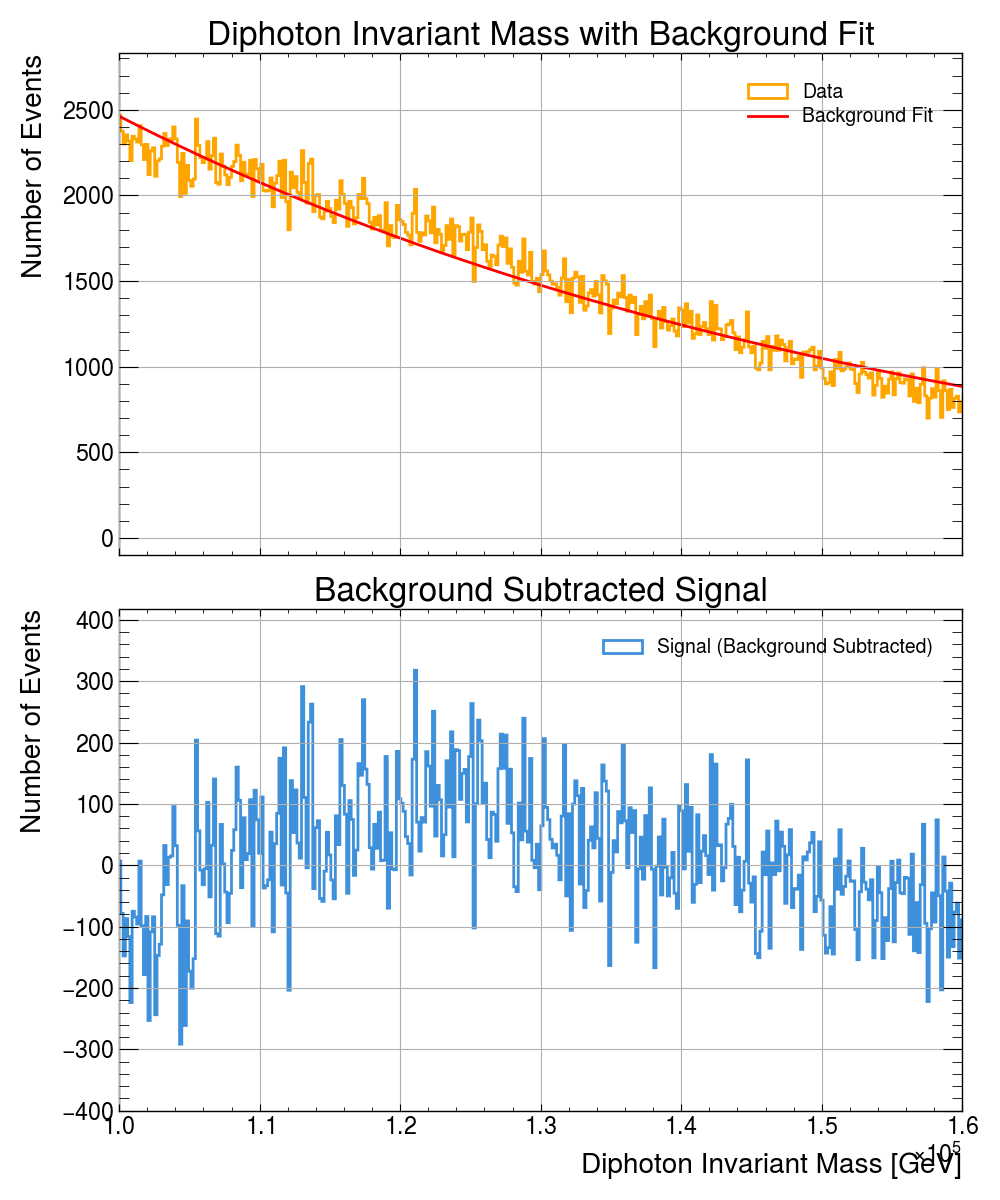

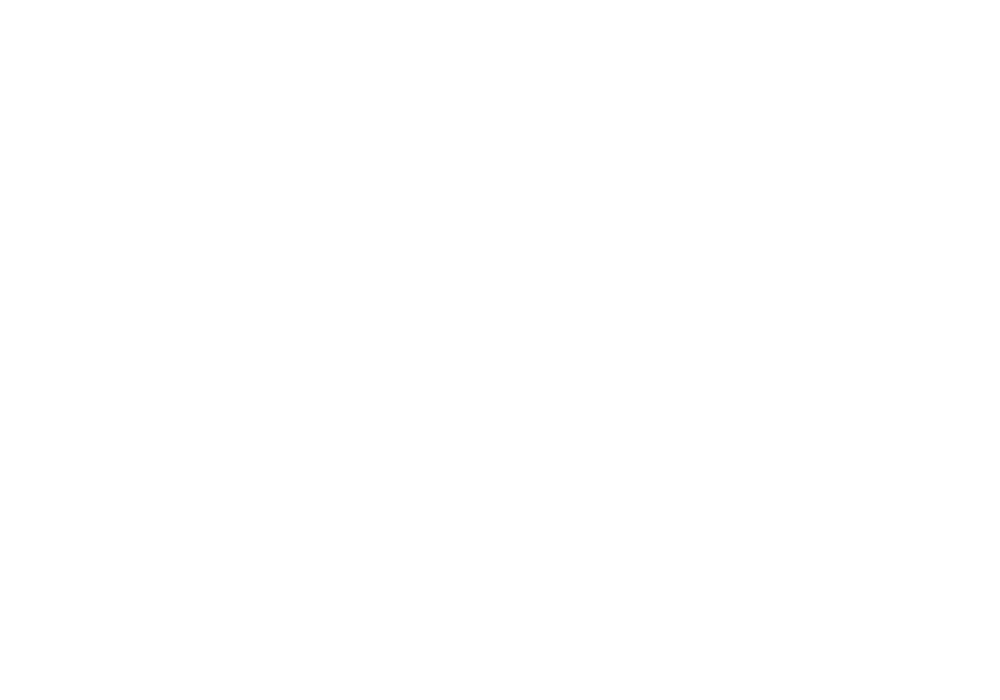

In [140]:
# Plotting the invariant mass distribution
plt.figure(figsize=(10, 7))
hist, bins, _ = plt.hist(masses, bins=10000, histtype='step', linewidth=2, label="Data")
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define an exponential function for the background
def poly_background(x, a, b):
    return a * np.exp(b * x)

param_a = 3500
param_b = 1/100000

# Fit the background in a sideband region (excluding the signal region)
sideband_mask = ((bin_centers > 1e5) & (bin_centers < 1.2e5)) | ((bin_centers > 1.3e5) & (bin_centers < 1.6e5)) # Exclude 115-135 GeV region
popt, _ = curve_fit(poly_background, bin_centers[sideband_mask], hist[sideband_mask], p0=(param_a, param_b))

# Calculate the background across the entire range
background = poly_background(bin_centers, *popt)

# Subtract the background from the original histogram
signal = hist - background

plt.clf()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Signal + Background fit
ax1.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Data", color="orange")
ax1.plot(bin_centers, background, 'r-', label="Background Fit", linewidth=2)
ax1.set_ylabel("Number of Events")
ax1.set_title("Diphoton Invariant Mass with Background Fit")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-100, max(hist)+100)

# Subplot 2: Background Subtracted Signal
ax2.hist(bin_centers, bins=bins, weights=signal, histtype='step', linewidth=2, label="Signal (Background Subtracted)")
ax2.set_xlabel("Diphoton Invariant Mass [GeV]")
ax2.set_ylabel("Number of Events")
ax2.set_title("Background Subtracted Signal")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-400, max(signal)+100)

# Apply ATLAS style for both plots
hep.style.use("ATLAS")

plt.xlim(1e5, 1.6e5)
plt.tight_layout()
plt.show()

In [141]:
# Assuming 'signal' contains the signal (background-subtracted data)
# and 'background' contains the fitted background

# Define the signal region (e.g., 115 GeV to 135 GeV)
signal_region_mask = (bin_centers > 1.2e5) & (bin_centers < 1.3e5)

# Calculate the total signal and background counts in the signal region
S = np.sum(signal[signal_region_mask])
B = np.sum(background[signal_region_mask])

# Calculate the significance
if B > 0:  # Prevent division by zero
    significance = S / np.sqrt(B)
    print(f"Significance: {significance}")
else:
    print("No background events in the region, significance is undefined.")




def asimov_significance(S, B):
    """Calculate the Asimov significance (Z_A) given signal (S) and background (B) counts."""
    if B > 0:
        return np.sqrt(2 * (S + B) * np.log(1 + S / B) - 2*S)
    else:
        return float('inf')  # In case there's no background, the significance is infinite

# Example usage:
S = 50  # Number of signal events
B = 100  # Number of background events

Z_A = asimov_significance(S, B)
print(f"Asimov significance: {Z_A}")

Significance: 20.104520280841413
Asimov significance: 4.65183108382595
